# Notebook example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

from src.data_source.spreadsheet import Spreadsheet
from src.preprocessing._preprocessing import Preprocessing
from src.model import TrainerSklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

/home/alex/projects/hermione_dev/project_test/project_test_env/lib/python3.8/site-packages/mlflow/types/schema.py:49: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary = (7, np.dtype("bytes"), "BinaryType", np.object)


Could not import lightgbm, required if using LGBMExplainableModel


In [4]:
df = Spreadsheet().get_data('../data/raw/train.csv')

In [5]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age'], dtype='object')

In [6]:
p = Preprocessing()

In [7]:
df = p.clean_data(df)
df = p.categ_encoding(df)

INFO:root:Cleaning data
INFO:root:Category encoding


In [8]:
df.head()

,Survived,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,0,0,1,0,1
1,1,38.0,1,0,0,1,0
2,1,26.0,0,0,1,1,0
3,1,35.0,1,0,0,1,0
4,0,35.0,0,0,1,0,1


In [9]:
X = df.drop(columns=["Survived"])
y = df["Survived"]

In [10]:
# Ensure the same random state passed to TrainerSkleran().train()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((499, 6), (215, 6), (499,), (215,))

In [11]:
rf = TrainerSklearn().train(X, y, classification=True, 
                            algorithm=RandomForestClassifier, 
                            preprocessing=p,
                           data_split=('train_test', {'test_size':.3}),
                           random_state=123)

INFO:interpret_community.TabularExplainer:Initialized valid explainer TreeExplainer with args {'explain_subset': None, 'features': ['Age', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male'], 'classes': None}


In [12]:
rf.get_metrics()

{'accuracy': 0.7767441860465116,
 'f1': 0.7272727272727273,
 'precision': 0.735632183908046,
 'recall': 0.7191011235955056,
 'roc_auc': 0.8491171749598716}

In [13]:
rf.get_columns()

['Age', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male']

In [14]:
rf.predict_proba(X_test, binary=True)

array([1.        , 0.47116667, 0.518     , 0.99666667, 0.58      ,
       0.        , 0.08706678, 0.        , 0.045     , 0.97      ,
       0.66058333, 0.12088798, 0.12088798, 0.99      , 0.82416667,
       0.28875   , 0.        , 0.60293432, 1.        , 0.        ,
       0.02688095, 1.        , 0.55566667, 0.76868254, 0.97      ,
       1.        , 0.0058422 , 1.        , 0.0075    , 0.1906815 ,
       0.        , 0.        , 1.        , 0.07107984, 0.        ,
       0.98166667, 0.60293432, 0.08376543, 0.18225144, 0.        ,
       0.03833333, 0.        , 0.30304762, 0.04      , 1.        ,
       0.4175    , 0.06      , 1.        , 1.        , 0.35062302,
       0.08706678, 0.99      , 0.        , 0.09      , 1.        ,
       0.60293432, 1.        , 0.        , 0.12088798, 0.00375   ,
       1.        , 1.        , 0.08706678, 0.        , 0.32579762,
       0.00875   , 0.00375   , 1.        , 0.        , 0.60293432,
       0.08706678, 0.09      , 0.3525    , 0.47416667, 0.60105

In [15]:
# Predicting new data
def predict_new(X, model, probs=True):
    X = p.clean_data(X)
    X = p.categ_encoding(X)
    
    columns = model.get_columns()
    for col in columns:
        if col not in X.columns:
            X[col] = 0
    print(X)
    if probs:
        return model.predict_proba(X)
    else:
        return model.predict(X)

In [16]:
new_data = pd.DataFrame({
    'Pclass':3,
    'Sex': 'male',
    'Age':4
}, index=[0])

new_data

,Pclass,Sex,Age
0,3,male,4


In [17]:
predict_new(new_data, rf)

INFO:root:Cleaning data
INFO:root:Category encoding


   Age  Pclass_3  Sex_male  Pclass_1  Pclass_2  Sex_female
0    4         1         1         0         0           0


array([[0.52583333, 0.47416667]])

**Get local explainer for each instance:**

In [18]:
# Get local explainer
res = rf.local_interpret(X_test, len(X_test.columns))

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [19]:
res

,Importance_Name_0,Importance_Name_1,Importance_Name_2,Importance_Name_3,Importance_Name_4,Importance_Name_5,Importance_Value_0,Importance_Value_1,Importance_Value_2,Importance_Value_3,Importance_Value_4,Importance_Value_5
0,Sex_female,Sex_male,Pclass_3,Pclass_2,Age,Pclass_1,1.0,0.986716,0.578907,0.271069,0.257027,0.0
1,Sex_female,Sex_male,Age,Pclass_2,Pclass_3,Pclass_1,1.0,0.965407,0.607668,0.488671,0.356583,0.0
2,Sex_female,Sex_male,Age,Pclass_2,Pclass_1,Pclass_3,1.0,0.963406,0.909294,0.388801,0.282151,0.0
3,Age,Sex_male,Sex_female,Pclass_2,Pclass_1,Pclass_3,1.0,0.969472,0.917643,0.166757,0.062946,0.0
4,Pclass_1,Age,Pclass_3,Pclass_2,Sex_male,Sex_female,1.0,0.818185,0.713251,0.559959,0.050245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
210,Age,Sex_female,Sex_male,Pclass_3,Pclass_2,Pclass_1,1.0,0.857279,0.794271,0.056703,0.012450,0.0
211,Sex_female,Sex_male,Age,Pclass_1,Pclass_3,Pclass_2,1.0,0.936626,0.677348,0.439749,0.281057,0.0
212,Sex_female,Sex_male,Pclass_1,Pclass_2,Age,Pclass_3,1.0,0.905212,0.709439,0.669674,0.350026,0.0
213,Sex_female,Sex_male,Pclass_3,Pclass_1,Pclass_2,Age,1.0,0.969143,0.965335,0.818807,0.789892,0.0


**Data Quality:**

In [20]:
from src.preprocessing import DataDrift
import great_expectations as ge

In [21]:
df = Spreadsheet().get_data('../data/raw/train.csv')

In [22]:
X_train, X_test = train_test_split(df, test_size=0.3, random_state=123)
X_train.shape, X_test.shape

((623, 4), (268, 4))

In [23]:
dq = DataDrift(discrete_cat_cols=['Sex', 'Pclass'])
df_ge = dq.check(X_train, target='Survived')

In [24]:
df_ge.save_expectation_suite('../data/output/expectations.json')

INFO:great_expectations.data_asset.data_asset:	7 expectation(s) included in expectation_suite. Omitting 1 expectation(s) that failed when last run; set discard_failed_expectations=False to include them. result_format settings filtered.


In [25]:
X_test.drop(columns=['Survived'], inplace=True)
df_ge = ge.dataset.PandasDataset(X_test)
ge_val = df_ge.validate(expectation_suite='../data/output/expectations.json', only_return_failures=False)

In [26]:
ge_val

{
  "statistics": {
    "evaluated_expectations": 7,
    "successful_expectations": 7,
    "unsuccessful_expectations": 0,
    "success_percent": 100.0
  },
  "results": [
    {
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "result": {
        "observed_value": [
          "Pclass",
          "Sex",
          "Age"
        ]
      },
      "success": true,
      "expectation_config": {
        "expectation_type": "expect_table_columns_to_match_ordered_list",
        "meta": {},
        "kwargs": {
          "column_list": [
            "Pclass",
            "Sex",
            "Age"
          ]
        }
      },
      "meta": {}
    },
    {
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "result": {
        "element_count": 268,
        "unexpected_count": 0,
        "unexpected_percent":

**Hypothesis testing**

In [27]:
import pandas as pd
from src.analysis import HTestAutoPilot, HypothesisTester

2021-12-22 22:37:12.130752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-22 22:37:12.130776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
invalid escape sequence \s
invalid escape sequence \s
invalid escape sequence \s


In [28]:
df = Spreadsheet().get_data('../data/raw/train.csv')

In [29]:
survived_age = df[(df.Survived == 1) & (df.Age.notnull())].Age.values
not_survived_age = df[(df.Survived == 0)  & (df.Age.notnull())].Age.values

At least one of the samples is not normally distributed and due to the number of observations the central limit theorem does not apply. In this case, the Mann-Whitney test is used as it does not make any assumptions about data ditribution (non-parametric alternative)


,T-test,MWU
T,-2.04603,-
dof,598.841215,-
cohen-d,0.157486,-
BF10,0.657,-
power,0.541418,-
U-val,-,57682.0
RBC,-,0.061776
CLES,-,0.469112
p-val,0.04119,0.160493
CI95%,"[-4.47, -0.09]","[-4.0, 1.0]"


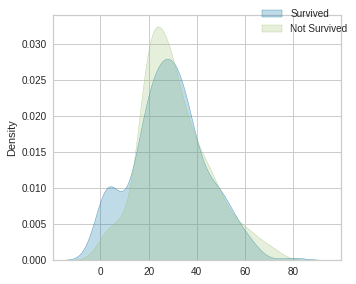

In [30]:
# If you want to compare distributions, but you are not sure if the data satisfy the parametric test conditions, 
# you can call the HTestAutoPilot Class.
# It will help you in this decision.
HTestAutoPilot.independent_difference(survived_age, not_survived_age, label1='Survived', label2='Not Survived')

In [31]:
# If you know which test to use, you can call it directly from the HypothesisTester Class
HypothesisTester.t_test(survived_age, not_survived_age, show_graph=False)

,T-test
T,-2.04603
dof,598.841215
alternative,two-sided
p-val,0.04119
CI95%,"[-4.47, -0.09]"
cohen-d,0.157486
BF10,0.657
power,0.541418
H0,difference in mean equal to zero
H1,difference in mean not equal to zero


**Dimensionality Reduction**

In [32]:
import pandas as pd
import numpy as np
from src.analysis import DimensionalityReducer

df = pd.DataFrame({'Col_1': [-1, -2, -3, 1, 2, 3], 'Col_2': [-1, -1, -2, 1, 1, 2], 'Col_3': [-5, -4, -3, 2, 1, 1]})

import pandas as pd
import numpy as np
from src.analysis import DimensionalityReducer

import pandas as pd
import numpy as np
from src.analysis import DimensionalityReducer

import pandas as pd
import numpy as np
from src.analysis import DimensionalityReducer

In [33]:
import pandas as pd
import numpy as np
from src.analysis import DimensionalityReducer

In [34]:
df = pd.DataFrame({'Col_1': [-1, -2, -3, 1, 2, 3], 'Col_2': [-1, -1, -2, 1, 1, 2], 'Col_3': [-5, -4, -3, 2, 1, 1]})

In [35]:
df

,Col_1,Col_2,Col_3
0,-1,-1,-5
1,-2,-1,-4
2,-3,-2,-3
3,1,1,2
4,2,1,1
5,3,2,1


In [36]:
dm = DimensionalityReducer(reducer='pca', columns=['Col_1', 'Col_2'], k=1)

In [37]:
dm.fit_transform(df, y='Col_3')

Explained variance (prefix_0): 0.9924428900898052


,Col_3,prefix_0
0,-5,1.383406
1,-4,2.221898
2,-3,3.605304
3,2,-1.383406
4,1,-2.221898
5,1,-3.605304
